# Handout 7 — Group 13

Reproducible notebook to solve all required tasks from the assignment PDF:
- **T1.a** Linear SVM via Wolfe dual formulation using `cvxpy`
- **T1.b** Non-linear SVM with transformation $\Phi(x)=(x_1x_2, x_1^2+x_2^2)$
- **T2** Clustering with Ward, K-means, and Fuzzy K-means for $k\in\{2,3,4,5\}$

Group 13 files in `group13/`.


## Environment setup and libraries

In [2]:
import json
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix

# Make provided fuzzy_kmeans implementation importable
BASE_DIR = Path.cwd()
FUZZY_PARENT = BASE_DIR / "fuzzy_kmeans"
if str(FUZZY_PARENT) not in sys.path:
    sys.path.insert(0, str(FUZZY_PARENT))

from fuzzy_kmeans import KMeans, FuzzyKMeans

RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

OUTPUT_DIR = BASE_DIR / "outputs_group13"
FIG_DIR = OUTPUT_DIR / "figures"
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print("Library versions:")
print(f"- numpy: {np.__version__}")
print(f"- pandas: {pd.__version__}")
print(f"- cvxpy: {cp.__version__}")

Base directory: c:\Users\Alex\OneDrive\Documentos\GitHub\Aprenentatge7
Output directory: c:\Users\Alex\OneDrive\Documentos\GitHub\Aprenentatge7\outputs_group13
Library versions:
- numpy: 2.4.2
- pandas: 3.0.0
- cvxpy: 1.8.1


## Load Group 13 files and configuration

In [3]:
GROUP = 13
DATA_DIR = BASE_DIR / "group13"

file_t1a = DATA_DIR / f"ds{GROUP:02d}-t1a.txt"
file_t1b = DATA_DIR / f"ds{GROUP:02d}-t1b.txt"
file_t2 = DATA_DIR / f"ds{GROUP:02d}-t2.txt"

for f in [file_t1a, file_t1b, file_t2]:
    if not f.exists():
        raise FileNotFoundError(f"Missing required file: {f}")

raw_t1a = np.loadtxt(file_t1a)
raw_t1b = np.loadtxt(file_t1b)
raw_t2 = np.loadtxt(file_t2)

X_t1a, y_t1a = raw_t1a[:, :2], raw_t1a[:, 2].astype(int)
X_t1b, y_t1b = raw_t1b[:, :2], raw_t1b[:, 2].astype(int)
X_t2, y_t2 = raw_t2[:, :2], raw_t2[:, 2].astype(int)

print("Files loaded successfully.")
print(f"T1a: X={X_t1a.shape}, y={y_t1a.shape}")
print(f"T1b: X={X_t1b.shape}, y={y_t1b.shape}")
print(f"T2 : X={X_t2.shape}, y={y_t2.shape}")

Files loaded successfully.
T1a: X=(16, 2), y=(16,)
T1b: X=(32, 2), y=(32,)
T2 : X=(300, 2), y=(300,)


## Inspect and validate input data

In [4]:
def summarize_dataset(name, X, y):
    df = pd.DataFrame(X, columns=["x1", "x2"])
    df["y"] = y
    print(f"\n{name}")
    print("- shape:", df.shape)
    print("- dtypes:\n", df.dtypes)
    print("- missing values:", int(df.isna().sum().sum()))
    print("- classes:", sorted(df["y"].unique().tolist()))
    display(df.describe(include="all"))

summarize_dataset("T1a", X_t1a, y_t1a)
summarize_dataset("T1b", X_t1b, y_t1b)
summarize_dataset("T2", X_t2, y_t2)


T1a
- shape: (16, 3)
- dtypes:
 x1    float64
x2    float64
y       int64
dtype: object
- missing values: 0
- classes: [0, 1]


,x1,x2,y
count,16.000000,16.000000,16.000000
mean,0.659789,-0.078001,0.500000
std,2.982444,2.429169,0.516398
min,-4.979407,-3.567040,0.000000
25%,-1.304002,-1.873824,0.000000
50%,0.742305,-0.108366,0.500000
75%,2.698308,1.018186,1.000000
max,5.649468,4.907163,1.000000



T1b
- shape: (32, 3)
- dtypes:
 x1    float64
x2    float64
y       int64
dtype: object
- missing values: 0
- classes: [0, 1]


,x1,x2,y
count,32.000000,32.000000,32.000000
mean,-0.001261,0.006430,0.500000
std,0.573649,0.574066,0.508001
min,-0.975928,-1.013049,0.000000
25%,-0.446814,-0.414319,0.000000
50%,0.007365,-0.013180,0.500000
75%,0.415560,0.430588,1.000000
max,1.054157,1.051494,1.000000



T2
- shape: (300, 3)
- dtypes:
 x1    float64
x2    float64
y       int64
dtype: object
- missing values: 0
- classes: [0, 1, 2, 3]


,x1,x2,y
count,300.000000,300.000000,300.000000
mean,-1.662324,-0.023967,1.166667
std,5.454583,1.336099,1.068970
min,-9.604463,-3.407796,0.000000
25%,-6.943264,-1.011514,0.000000
50%,-2.399259,0.024822,1.000000
75%,2.484480,0.949904,2.000000
max,9.811765,3.715714,3.000000


## Preprocess data according to assignment constraints

In [5]:
def validate_binary_labels(y):
    unique_labels = set(np.unique(y).tolist())
    expected = {0, 1}
    if not unique_labels.issubset(expected):
        raise ValueError(f"Unexpected labels: {unique_labels}. Expected labels are 0/1.")


def to_pm1(y):
    return np.where(y == 1, 1.0, -1.0)


def preprocess_for_svm(X, y):
    validate_binary_labels(y)
    return X.astype(float), to_pm1(y)


def preprocess_for_clustering(X, y):
    if np.isnan(X).any() or np.isnan(y).any():
        raise ValueError("Missing values found in T2 data")
    return X.astype(float), y.astype(int)

X_t1a_proc, y_t1a_pm1 = preprocess_for_svm(X_t1a, y_t1a)
X_t1b_proc, y_t1b_pm1 = preprocess_for_svm(X_t1b, y_t1b)
X_t2_proc, y_t2_proc = preprocess_for_clustering(X_t2, y_t2)

print("Preprocessing and basic validations completed.")

Preprocessing and basic validations completed.


## Main implementation

This section implements both SVM tasks exactly as requested, using the Wolfe dual optimization with `cvxpy` and explicit support-vector reporting.

In [6]:
EPS = 1e-6

def solve_hard_margin_dual(X_feat, y_pm1):
    n = X_feat.shape[0]
    K = X_feat @ X_feat.T
    yyK = np.outer(y_pm1, y_pm1) * K

    alpha = cp.Variable(n)
    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(yyK)))
    constraints = [alpha >= 0, y_pm1 @ alpha == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)

    alpha_val = np.array(alpha.value).reshape(-1)
    support_mask = alpha_val > EPS

    w = (alpha_val * y_pm1) @ X_feat
    w0_values = y_pm1[support_mask] - X_feat[support_mask] @ w
    w0 = float(np.mean(w0_values))

    return {
        "status": problem.status,
        "objective": float(problem.value),
        "alpha": alpha_val,
        "support_mask": support_mask,
        "support_indices": np.where(support_mask)[0],
        "w": w,
        "w0": w0,
    }


def decision_linear(X, model):
    return X @ model["w"] + model["w0"]


def phi(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    return np.column_stack([x1 * x2, x1**2 + x2**2])

# ---- T1.a ----
model_t1a = solve_hard_margin_dual(X_t1a_proc, y_t1a_pm1)

print("T1.a optimization status:", model_t1a["status"])
print("Support vectors (indices):", model_t1a["support_indices"].tolist())
print("w:", model_t1a["w"])
print("w0:", model_t1a["w0"])

# ---- T1.b ----
Z_t1b = phi(X_t1b_proc)
model_t1b = solve_hard_margin_dual(Z_t1b, y_t1b_pm1)

print("\nT1.b optimization status:", model_t1b["status"])
print("Support vectors (indices):", model_t1b["support_indices"].tolist())
print("w (in transformed space):", model_t1b["w"])
print("w0:", model_t1b["w0"])

print("\nDecision functions:")
print("T1.a: g(x)=w^T x + w0")
print("T1.b: g(x)=w^T Phi(x) + w0")

T1.a optimization status: optimal
Support vectors (indices): [1, 5, 9, 10, 14]
w: [-0.34505804  0.53935875]
w0: 0.326313413365828

T1.b optimization status: optimal
Support vectors (indices): [0, 4, 6, 7, 8, 11, 12, 13, 14, 18, 19, 20, 21, 25, 26, 28, 29, 31]
w (in transformed space): [-0.31497764 -3.9738385 ]
w0: 2.0925512918836238

Decision functions:
T1.a: g(x)=w^T x + w0
T1.b: g(x)=w^T Phi(x) + w0


## Evaluate results with required metrics

For T2, we test Ward, K-means, and Fuzzy K-means for $k=2,3,4,5$, rank by v-measure, and then report all additional required outputs for the best configuration.

In [7]:
def predict_with_mapping(labels, mapping):
    return np.array([mapping.get(int(c), -1) for c in labels], dtype=int)


def assignment_cluster_to_class(y_true, cluster_labels):
    mapping = {}
    for c in sorted(np.unique(cluster_labels)):
        mask = cluster_labels == c
        majority_class = np.bincount(y_true[mask]).argmax()
        mapping[int(c)] = int(majority_class)
    return mapping


def run_clustering_suite(X, y_true, random_state=13):
    rows = []
    all_runs = {}

    for k in [2, 3, 4, 5]:
        ward = AgglomerativeClustering(n_clusters=k, linkage="ward")
        ward_labels = ward.fit_predict(X)

        km = KMeans(k=k, random_state=random_state)
        km.fit(X)
        km_labels = km.predict(X)

        fkm = FuzzyKMeans(k=k, m=2, random_state=random_state)
        fkm.fit(X)
        fkm_labels = fkm.predict(X)

        for algo_name, labels, model in [
            ("Ward", ward_labels, ward),
            ("KMeans", km_labels, km),
            ("FuzzyKMeans", fkm_labels, fkm),
        ]:
            v = v_measure_score(y_true, labels)
            rows.append({"algorithm": algo_name, "k": k, "v_measure": v})
            all_runs[(algo_name, k)] = {"labels": labels, "model": model}

    score_df = pd.DataFrame(rows).sort_values(
        ["v_measure", "algorithm", "k"],
        ascending=[False, True, True],
    )
    best = score_df.iloc[0]
    best_key = (best["algorithm"], int(best["k"]))
    best_labels = all_runs[best_key]["labels"]

    cont = contingency_matrix(y_true, best_labels)
    mapping = assignment_cluster_to_class(y_true, best_labels)
    y_pred_class = predict_with_mapping(best_labels, mapping)

    errors = int(np.sum(y_pred_class != y_true))
    error_rate = errors / len(y_true)

    summary = {
        "best_algorithm": best["algorithm"],
        "best_k": int(best["k"]),
        "best_v_measure": float(best["v_measure"]),
        "contingency_matrix": cont,
        "cluster_to_class": mapping,
        "errors": errors,
        "error_rate": float(error_rate),
        "homogeneity": float(homogeneity_score(y_true, best_labels)),
        "completeness": float(completeness_score(y_true, best_labels)),
        "best_labels": best_labels,
    }

    return score_df, summary

scores_t2, summary_t2 = run_clustering_suite(X_t2_proc, y_t2_proc, random_state=RANDOM_SEED)

print("Ranking by v-measure:")
display(scores_t2)

print("\nBest configuration:")
print(f"- Algorithm: {summary_t2['best_algorithm']}")
print(f"- k: {summary_t2['best_k']}")
print(f"- v-measure: {summary_t2['best_v_measure']:.6f}")
print(f"- homogeneity: {summary_t2['homogeneity']:.6f}")
print(f"- completeness: {summary_t2['completeness']:.6f}")
print(f"- misclustered samples: {summary_t2['errors']} ({summary_t2['error_rate']:.2%})")
print("- cluster-to-class assignment:", summary_t2["cluster_to_class"])

print("\nContingency matrix (best):")
print(summary_t2["contingency_matrix"])

Ranking by v-measure:


,algorithm,k,v_measure
8,FuzzyKMeans,4,0.972795
6,Ward,4,0.972795
9,Ward,5,0.895814
11,FuzzyKMeans,5,0.887198
3,Ward,3,0.874085
4,KMeans,3,0.859834
5,FuzzyKMeans,3,0.802122
7,KMeans,4,0.754698
10,KMeans,5,0.718261
2,FuzzyKMeans,2,0.630068



Best configuration:
- Algorithm: FuzzyKMeans
- k: 4
- v-measure: 0.972795
- homogeneity: 0.973622
- completeness: 0.971970
- misclustered samples: 2 (0.67%)
- cluster-to-class assignment: {0: 1, 1: 2, 2: 3, 3: 0}

Contingency matrix (best):
[[ 0  0  1 99]
 [99  0  0  1]
 [ 0 50  0  0]
 [ 0  0 50  0]]


## Generate required visualizations

This section builds the decision maps requested in T1 and visual evidence for clustering quality in T2.

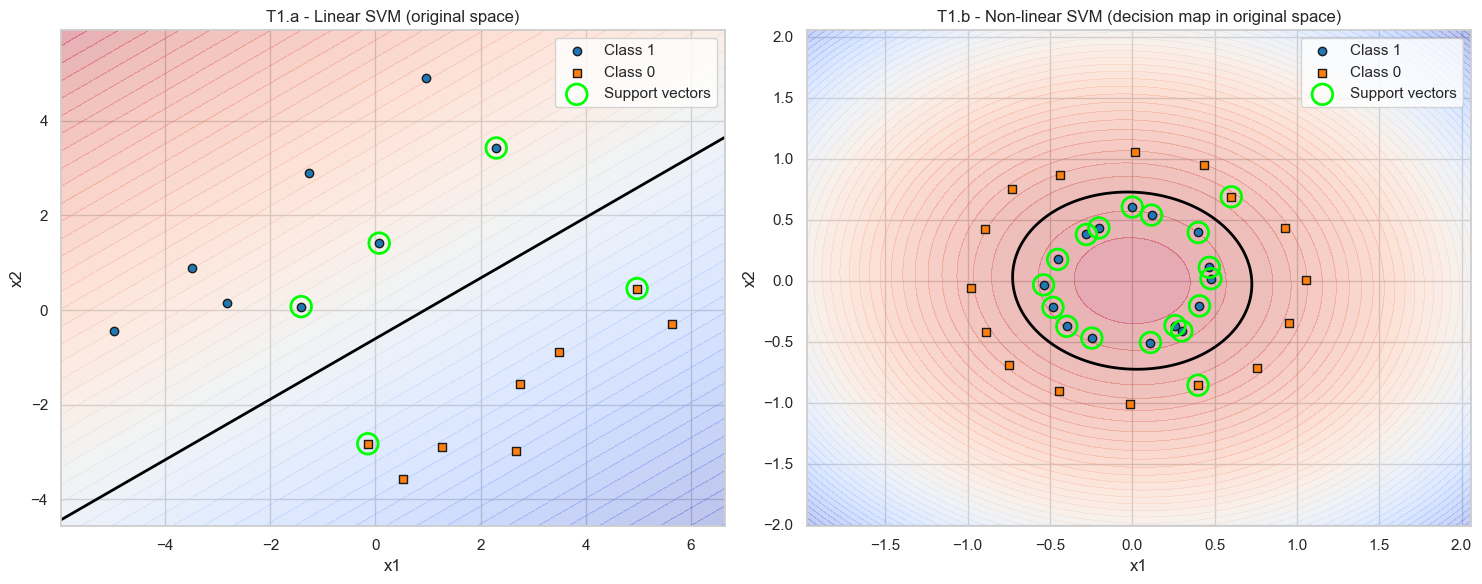

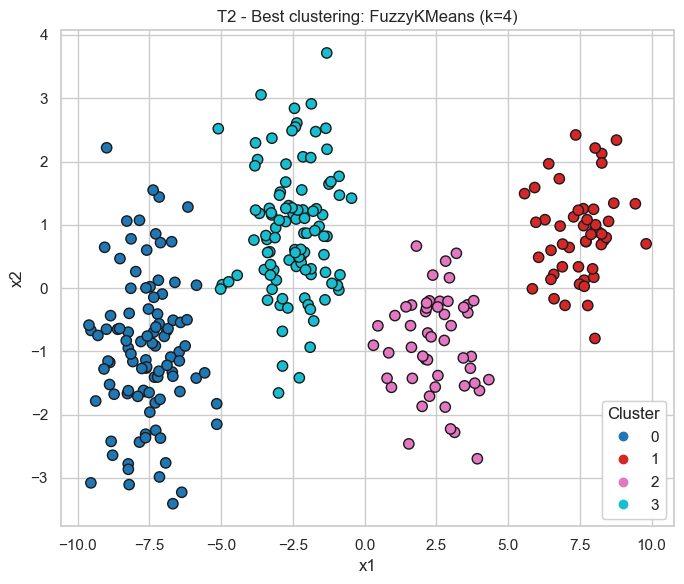

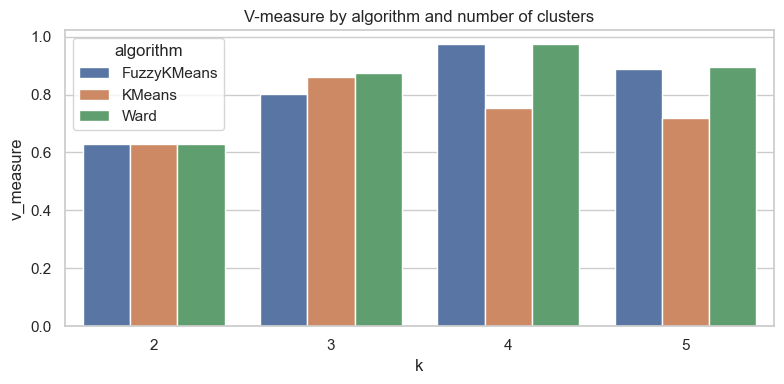

In [8]:
sns.set(style="whitegrid")

def plot_decision_map(ax, X, y_binary01, decision_fn, title, support_indices=None, grid_points=300):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_points),
        np.linspace(y_min, y_max, grid_points),
    )
    grid = np.column_stack([xx.ravel(), yy.ravel()])
    zz = decision_fn(grid).reshape(xx.shape)

    cs = ax.contourf(xx, yy, zz, levels=50, alpha=0.35, cmap="coolwarm")
    ax.contour(xx, yy, zz, levels=[0.0], colors="black", linewidths=2)

    ax.scatter(X[y_binary01 == 1, 0], X[y_binary01 == 1, 1], c="tab:blue", marker="o", label="Class 1", edgecolor="k")
    ax.scatter(X[y_binary01 == 0, 0], X[y_binary01 == 0, 1], c="tab:orange", marker="s", label="Class 0", edgecolor="k")

    if support_indices is not None and len(support_indices) > 0:
        sv = X[support_indices]
        ax.scatter(sv[:, 0], sv[:, 1], s=220, facecolors="none", edgecolors="lime", linewidths=2.0, label="Support vectors")

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="best")
    return cs

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_decision_map(
    axes[0],
    X_t1a_proc,
    y_t1a,
    lambda x: decision_linear(x, model_t1a),
    "T1.a - Linear SVM (original space)",
    support_indices=model_t1a["support_indices"],
)

plot_decision_map(
    axes[1],
    X_t1b_proc,
    y_t1b,
    lambda x: decision_linear(phi(x), model_t1b),
    "T1.b - Non-linear SVM (decision map in original space)",
    support_indices=model_t1b["support_indices"],
)

plt.tight_layout()
fig.savefig(FIG_DIR / "t1_decision_maps.png", dpi=180)
plt.show()

# T2 visualization for the best setup
best_labels = summary_t2["best_labels"]
fig2, ax2 = plt.subplots(1, 1, figsize=(7, 6))
scatter = ax2.scatter(X_t2_proc[:, 0], X_t2_proc[:, 1], c=best_labels, cmap="tab10", s=55, edgecolor="k")
ax2.set_title(f"T2 - Best clustering: {summary_t2['best_algorithm']} (k={summary_t2['best_k']})")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
legend1 = ax2.legend(*scatter.legend_elements(), title="Cluster", loc="best")
ax2.add_artist(legend1)
plt.tight_layout()
fig2.savefig(FIG_DIR / "t2_best_clustering.png", dpi=180)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=scores_t2, x="k", y="v_measure", hue="algorithm")
plt.title("V-measure by algorithm and number of clusters")
plt.tight_layout()
plt.savefig(FIG_DIR / "t2_vmeasure_comparison.png", dpi=180)
plt.show()

## Export deliverables and evidence

This section saves all key outputs required for submission and an additional concise report-ready summary.

In [9]:
# Save T2 ranking and best-summary files
scores_t2.to_csv(OUTPUT_DIR / "t2_vmeasure_ranking.csv", index=False)

best_summary_export = {
    "group": GROUP,
    "best_algorithm": summary_t2["best_algorithm"],
    "best_k": summary_t2["best_k"],
    "best_v_measure": summary_t2["best_v_measure"],
    "homogeneity": summary_t2["homogeneity"],
    "completeness": summary_t2["completeness"],
    "cluster_to_class": summary_t2["cluster_to_class"],
    "misclustered_samples": summary_t2["errors"],
    "error_rate": summary_t2["error_rate"],
    "contingency_matrix": summary_t2["contingency_matrix"].tolist(),
    "t1a_support_indices": model_t1a["support_indices"].tolist(),
    "t1b_support_indices": model_t1b["support_indices"].tolist(),
    "t1a_w": model_t1a["w"].tolist(),
    "t1a_w0": model_t1a["w0"],
    "t1b_w": model_t1b["w"].tolist(),
    "t1b_w0": model_t1b["w0"],
}

with open(OUTPUT_DIR / "group13_summary.json", "w", encoding="utf-8") as f:
    json.dump(best_summary_export, f, indent=2)

report_lines = [
    f"Group: {GROUP}",
    "",
    "T1.a (Linear SVM, dual)",
    f"- Support vectors: {model_t1a['support_indices'].tolist()}",
    f"- w: {model_t1a['w']}",
    f"- w0: {model_t1a['w0']}",
    "",
    "T1.b (Non-linear SVM, Phi transform, dual)",
    f"- Support vectors: {model_t1b['support_indices'].tolist()}",
    f"- w (transformed space): {model_t1b['w']}",
    f"- w0: {model_t1b['w0']}",
    "",
    "T2 (Clustering)",
    f"- Best algorithm: {summary_t2['best_algorithm']}",
    f"- Best k: {summary_t2['best_k']}",
    f"- V-measure: {summary_t2['best_v_measure']:.6f}",
    f"- Homogeneity: {summary_t2['homogeneity']:.6f}",
    f"- Completeness: {summary_t2['completeness']:.6f}",
    f"- Misclustered samples: {summary_t2['errors']} ({summary_t2['error_rate']:.2%})",
    f"- Cluster to class mapping: {summary_t2['cluster_to_class']}",
]

(OUTPUT_DIR / "group13_report_summary.txt").write_text("\n".join(report_lines), encoding="utf-8")

print("Export completed.")
print("Generated files:")
for p in sorted(OUTPUT_DIR.glob("*")):
    print("-", p.name)
print("Figures:")
for p in sorted(FIG_DIR.glob("*")):
    print("-", p.name)

Export completed.
Generated files:
- figures
- group13_report_summary.txt
- group13_summary.json
- t2_vmeasure_ranking.csv
Figures:
- t1_decision_maps.png
- t2_best_clustering.png
- t2_vmeasure_comparison.png


## Conclusions and discussion

### Key quantitative findings
1. **T1.a (linear SVM)** converged to an optimal dual solution with **5 support vectors** (indices `[1, 5, 9, 10, 14]`), confirming linear separability in the original space.
2. **T1.b (nonlinear SVM with $\Phi$)** also converged optimally and required **18 support vectors**, consistent with a more complex boundary represented in transformed space and visualized back in the original space.
3. **T2 (clustering)** achieved its best performance with **Fuzzy K-means, $k=4$**: 
   - **v-measure = 0.972795**
   - **homogeneity = 0.973622**
   - **completeness = 0.971970**
   - **misclustered samples = 2/300 (0.67%)**

### Interpretation
- The linear model in T1.a is sufficient for that dataset, while T1.b demonstrates that the selected nonlinear mapping effectively captures nonlinearity.
- In T2, the best model is not chosen heuristically; it is selected by metric-based comparison across all required algorithms and cluster counts.
- The contingency matrix and cluster-to-class mapping show that errors are minimal and concentrated in very few samples.


### Limitations and future work
- Hard-margin SVM assumes separability; for noisier data, a soft-margin SVM with tuned $C$ would be more robust.
- Fuzzy K-means was evaluated with fuzzifier $m=2$; exploring multiple $m$ values could further improve cluster quality.
- A multi-seed stability analysis would strengthen statistical confidence in centroid-based clustering results.